# Social graphs and interactions

# Assignment 1

**Group 30:**

Aleksandar Lukic, s194066

Clara Mejlhede Lorenzen, s180350

Julia Katarzyna Zalewska, s244491

## Python libraries used in this assignment

In [57]:
import json
import math
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import random
import re
import urllib.request

## Part 1: Exploring the friendship paradox.

In [2]:
# Create an initial graph with a single link (connecting 0 and 1)
G = nx.Graph()
G.add_edge(0, 1)

# Add nodes, connecting each to the existing nodes with probability proportional to their degree
def add_node_with_preferential_attachment(G, new_node):
    
    degrees = [node for node, degree in G.degree() for _ in range(degree)]
    
    # attach the new node to existing node
    chosen_node = random.choice(degrees)
    G.add_edge(new_node, chosen_node)

# Keep going until you have a 100 node network.
for i in range(2, 100):
    add_node_with_preferential_attachment(G, i)

# Add more nodes until you have a 5000 node network.
for i in range(100, 5000):
    add_node_with_preferential_attachment(G, i)

# What's the maximum and minimum degree?
degrees = [degree for node, degree in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)

# Bin the degree distribution using numpy.histogram.
hist, bin_edges = np.histogram(degrees, bins=range(min_degree, max_degree + 2), density=True)

#### The friendship paradox in BA networks

<font color='gray'> Pick a node i at random (e.g. use random.choice). Find its degree.</font>

In [4]:
# Find random node i 
random_node = random.choice(list(G.nodes))

# Find its degree
node_degree = G.degree[random_node]
print(f"Degree of node_i {random_node}: {node_degree}")

Degree of node_i 4877: 1


<font color='gray'> Find i's neighbors. And calculate their average degree.</font>

In [6]:
# Find neighbors and their degrees
neighbors = list(G.neighbors(random_node))
neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]

# Calculate neighbors_degree 
if len(neighbor_degrees) > 0:
    neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
else:
    neighbor_degree = 0

print(f"Degree of neighbor_i {random_node}: {neighbor_degree}")

Degree of neighbor_i 4877: 53.0


<font color='gray'> Compare the two numbers to check if it's true that i's friends (on average) have more friends than i.</font>

In [7]:
if node_degree < neighbor_degree:
    print("It is true, i's friends has more friends than i") 
else:
    print("It is not true, i has more friends than i's friends")

It is true, i's friends has more friends than i


<font color='gray'> Do this 1000 times. How many out of those 1000 times is the friendship paradox true in F-BA?</font>

In [8]:
t = 0
f = 0

for i in range(1000):
    # Find random node i 
    random_node = random.choice(list(G.nodes))

    # Find its degree
    node_degree = G.degree[random_node]    
    
    # Find neighbors and their degrees
    neighbors = list(G.neighbors(random_node))
    neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]

    # Calculate neighbors_degree 
    if len(neighbor_degrees) > 0:
        neighbor_degree = sum(neighbor_degrees) / len(neighbor_degrees)
    else:
        neighbor_degree = 0
    
    if node_degree < neighbor_degree:
        t += 1 
    else:
        f += 1

print(f"The friendship paradox is true {t} times and false {f} times out of 1000 times in total")

The friendship paradox is true 872 times and false 128 times out of 1000 times in total


#### The friendship paradox more generally

<font color='gray'> What if the power law is flatter, e.g. p(k)∼k^(−γ) with γ=2? Will the fraction of times the paradox is true be higher or lower?</font>

Since the power-law distribution is skewed, when γ=2, the fraction of times the paradox is true will be higher. 

* For a steep power-law, the nodes will have low degrees, and only a few hubs will exist.

* For a flatter power-law, there are more high-degree nodes, meaning that many more nodes are relatively well-connected.

<font color='gray'> First answer this question by simply reasoning. Think about what it would mean in terms of hubs that the power law is flatter?</font>

With a flatter power law, the gap between a node and the hubs is smaller because hubs will be more common. 

A randomly chosen node is likely to have neighbors with similar degrees. Therefore, the Friendship Paradox (the idea that your friends have more friends than you) will hold more frequently since there are many well-connected nodes in the neighborhood of any given node.

<font color='gray'> Now simulate a new network with the slope mentioned above. You can generate networks with power-law degree 
distributions using the configuation model. The networkx funtion is here nx.configuration_model. I suggest you make the network pretty big ... let's say 5000 nodes or more.</font>

We will below make the simulation by defining the degrees and ensuring that the sum of the degrees are even. Then creating the configuration model graph and removing the parallel edges and self-loops

This will give an idea of how the "slope" can look like. Similar to a power-law graph.

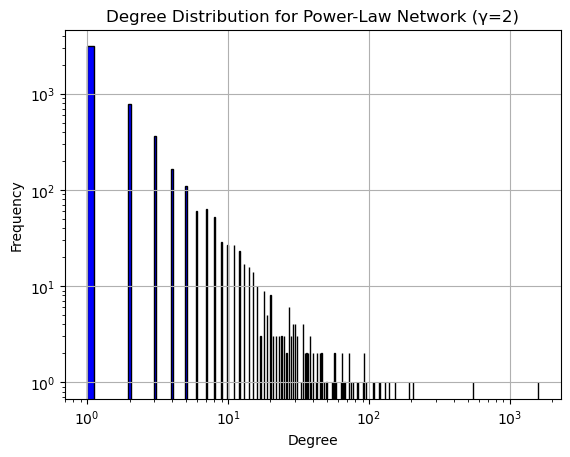

In [9]:
n = 5000  # Number of nodes
gamma = 2  # Power-law exponent

# Degrees following p(k) ~ k^(-gamma)
degree_sequence = np.random.zipf(gamma, n)

# Ensure the sum of degrees is even 
if sum(degree_sequence) % 2 != 0:
    degree_sequence[0] += 1

# Create the configuration model graph with the degree sequence
G = nx.configuration_model(degree_sequence)

# Remove parallel edges and self-loops
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# Plot the degree distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins='auto', color='blue', edgecolor='black')

plt.title('Degree Distribution for Power-Law Network (γ=2)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')  # Log-log plot to visualize the power-law behavior
plt.grid(True)
plt.show()


<font color='gray'> Did you reason correctly above? For what fraction of the time is the friendship paradox true for your network with a new slope?</font>

Below we are calculating the fraction of times the Friendship Paradox is true  

In [10]:
# Initialize counts for the friendship paradox
paradox_true = 0
paradox_false = 0

# Testing the test n times
n = 1000

for _ in range(n):
    
    random_node = random.choice(list(G.nodes))
    node_degree = G.degree[random_node]
    neighbors = list(G.neighbors(random_node))
    
    # Find the degree of neighbors
    if len(neighbors) > 0:
        neighbor_degrees = [G.degree[neighbor] for neighbor in neighbors]
        avg_neighbor_degree = np.mean(neighbor_degrees)
    
    else:
        avg_neighbor_degree = 0
    
    # Checking if friendship paradox holds
    if node_degree < avg_neighbor_degree:
        paradox_true += 1
    
    else:
        paradox_false += 1

fraction_true = paradox_true / (paradox_true + paradox_false)
print(f"Friendship Paradox is true {fraction_true*100}% of the time")

Friendship Paradox is true 90.5% of the time


#### The friendship paradox and the configuration model

<font color='gray'> Now generate a network for the configuration model that has the same slope and number of nodes as F-BA* in A 
above; let's call this new network F-CM* (for friendship configuration model).</font>

We will here generate a new network for the configuration model with the same slope and number of nodes as for the F-BA. This is done by generating the degree sequence from F-BA and then creating a configuration model based on that degree sequence. We then convert it to a graph with no multi-edges or self-loops and plot the F-CM network.

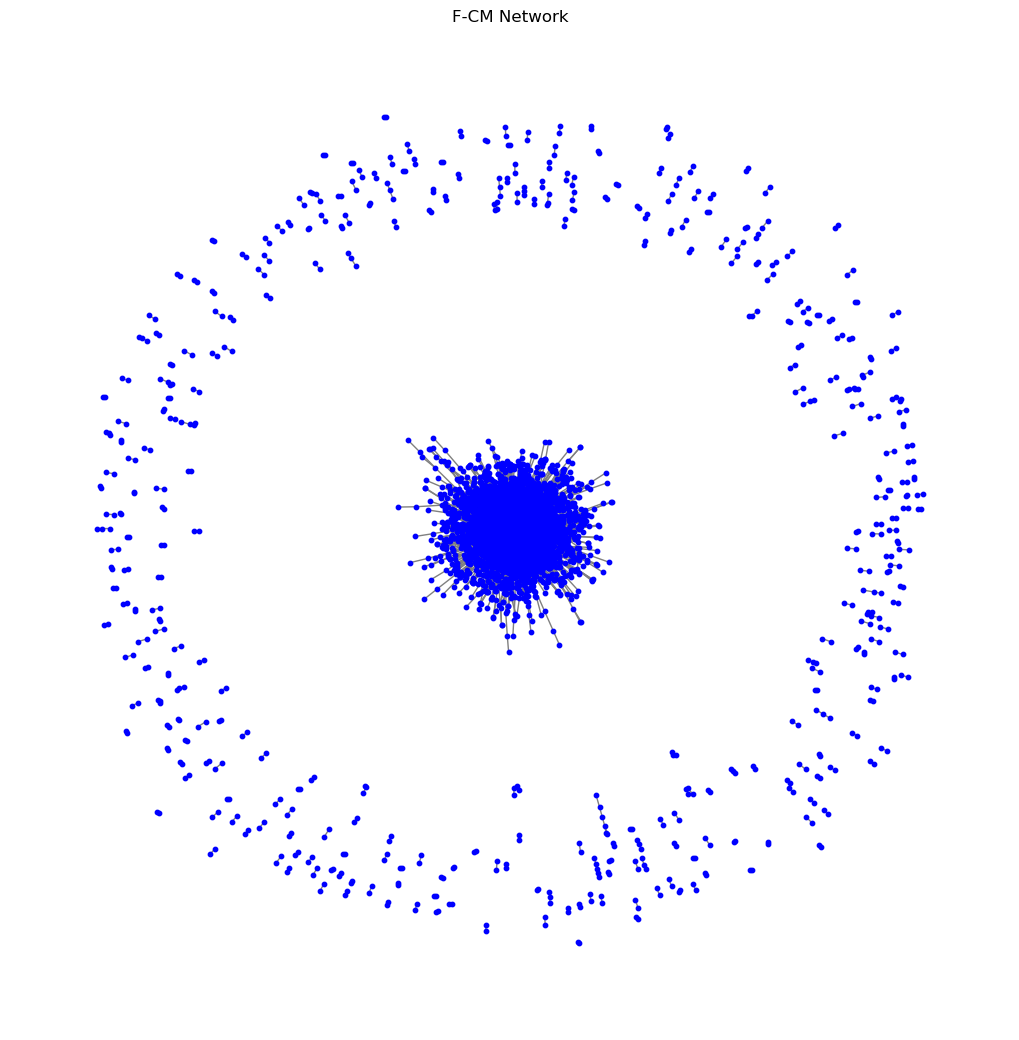

In [11]:
# Using the degree sequence from the F-BA network
degree_sequence = [G.degree(n) for n in G.nodes()]

# Generate the configuration model, F-CM
F_CM_star = nx.configuration_model(degree_sequence)

# Convert to graph
F_CM_star = nx.Graph(F_CM_star)
F_CM_star.remove_edges_from(nx.selfloop_edges(F_CM_star))

# Plot the F-CM Network
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(F_CM_star, seed=42)
nx.draw(F_CM_star, pos, node_size=10, edge_color="gray", node_color="blue", with_labels=False)

plt.title("F-CM Network")
plt.show()

<font color='gray'> What fraction of the time is the friendship paradox is true for the F-CM network?</font>

We will now calculate the fraction of times, for the F-CM network, where the Friendship Paradox is true.

In [14]:
# Initialize counts for the friendship paradox
paradox_true_FCM = 0
paradox_false_FCM = 0

# Testing the test n times
n = 1000

for _ in range(n):
    random_node = random.choice(list(F_CM_star.nodes))

    node_degree = F_CM_star.degree[random_node]

    neighbors = list(F_CM_star.neighbors(random_node))

    # Find the degree of neighbors
    if len(neighbors) > 0:
        neighbor_degrees = [F_CM_star.degree[neighbor] for neighbor in neighbors]
        avg_neighbor_degree = np.mean(neighbor_degrees)
    else:
        avg_neighbor_degree = 0
    
    # Checking if friendship paradox holds
    if node_degree < avg_neighbor_degree:
        paradox_true_FCM += 1
    else:
        paradox_false_FCM += 1

fraction_true_FCM = paradox_true_FCM / (paradox_true_FCM + paradox_false_FCM)
print(f"The Friendship Paradox is true {fraction_true_FCM*100}% of the time in F-CM")

The Friendship Paradox is true 84.1% of the time in F-CM


<font color='gray'> Assuming that F-BA and F-CM have the same degree sequence can now think about if F-BA and F-CM are different with respect to the friendship paradox. Specifically, please explain your thoughts on the following topics </font>

Even with the same degree sequence. There will still be a differences between F-BA and F-CM. 

* The degree correlation will still be different. The F-CM's connections will be more random  than the F-BA's connections. This could result in a lower Friendship Paradox clustering for the F-CM since it will reduce the likelihood of the paradox occuring compared to the F-BA.  

* The clustering will tell us how interconnected a node's neighbors are and in F-CM the cluster coefficient will be lower that F-BA.

#### Growth without preferential attachment

<font color='gray'> Finally, we'll build a network of same size and degree as in the exercise above, using the growth mechanism without the preferential attachment. Follow the steps below for success </font>

1. <font color='gray'> Grow a new network (the Sune-network) with the same parameters as the F-BA network in the exercise above, i.e. 5000 nodes, each new node connects to the existing network, but with one key difference: have the incoming nodes connect to the existing nodes with equal probability. This is the Sune-network.</font>

Below we have created the Sune-network. First we initialize the network with two connecting nodes and are then able to grow the network to our parameters as the F-BA network, i.e. 5000 nodes. 

The Sune-network will grow similarly to the F-BA network but with each incoming nodes connects to the existing nodes with equal probability of receiving a new connection.

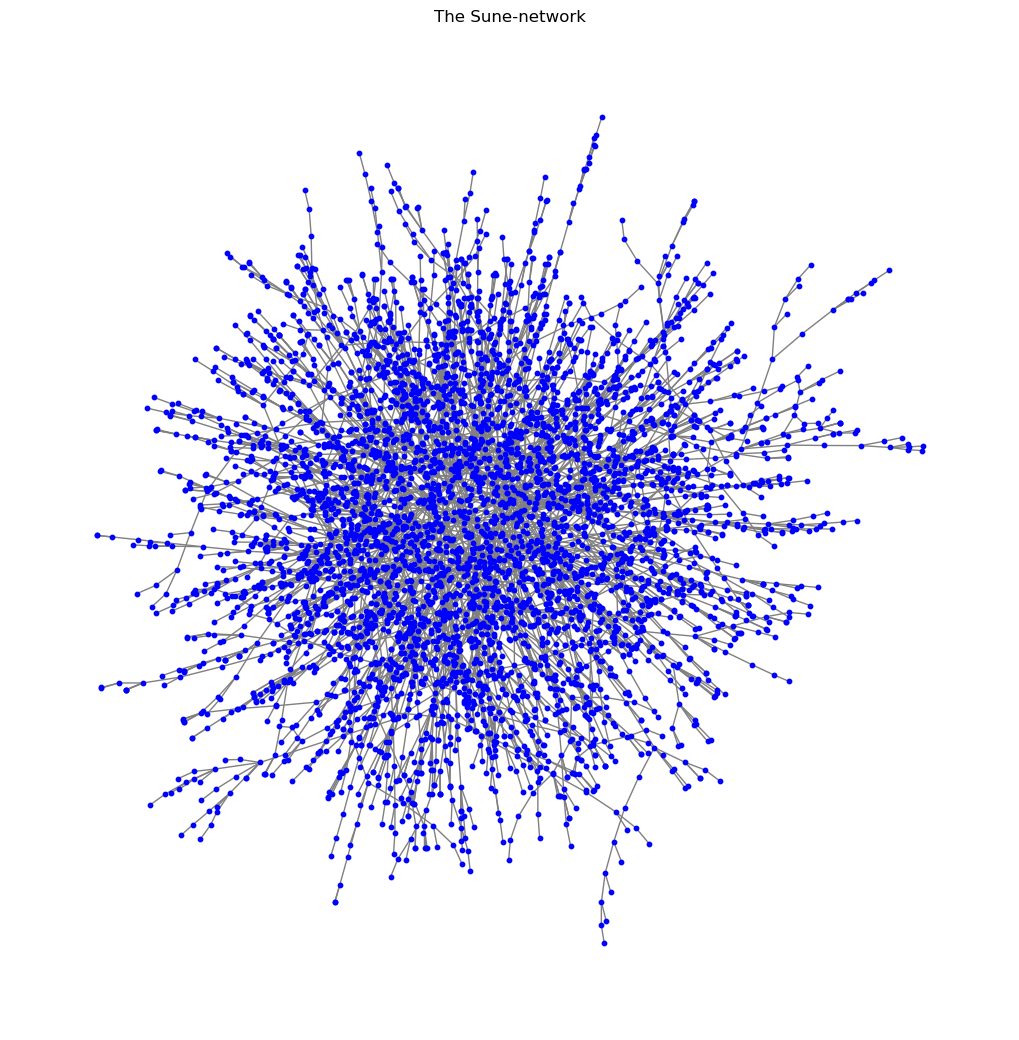

In [15]:
# Initialize the network with 2 connected nodes
Sune_network = nx.Graph()
Sune_network.add_edge(0, 1)

# Number of nodes in the final network
num_nodes = 5000

# Grow the network
for new_node in range(2, num_nodes):
    target_node = random.choice(list(Sune_network.nodes))
    Sune_network.add_edge(new_node, target_node)

# Plot the Sune-network
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(Sune_network, seed=42)
nx.draw(Sune_network, pos, node_size=10, edge_color="gray", node_color="blue", with_labels=False)

plt.title("The Sune-network")
plt.show()

2. <font color='gray'> Generate an ER network of same number of nodes and links as the Sune-network.</font>

To generate an ER network of same number of nodes and links as above, we will first count the number of edges in the Sune-network and afterwerds generate an ER network with the same number of nodes and edges.

The ER network is a random network where edges are placed between nodes with a fixed probability. 

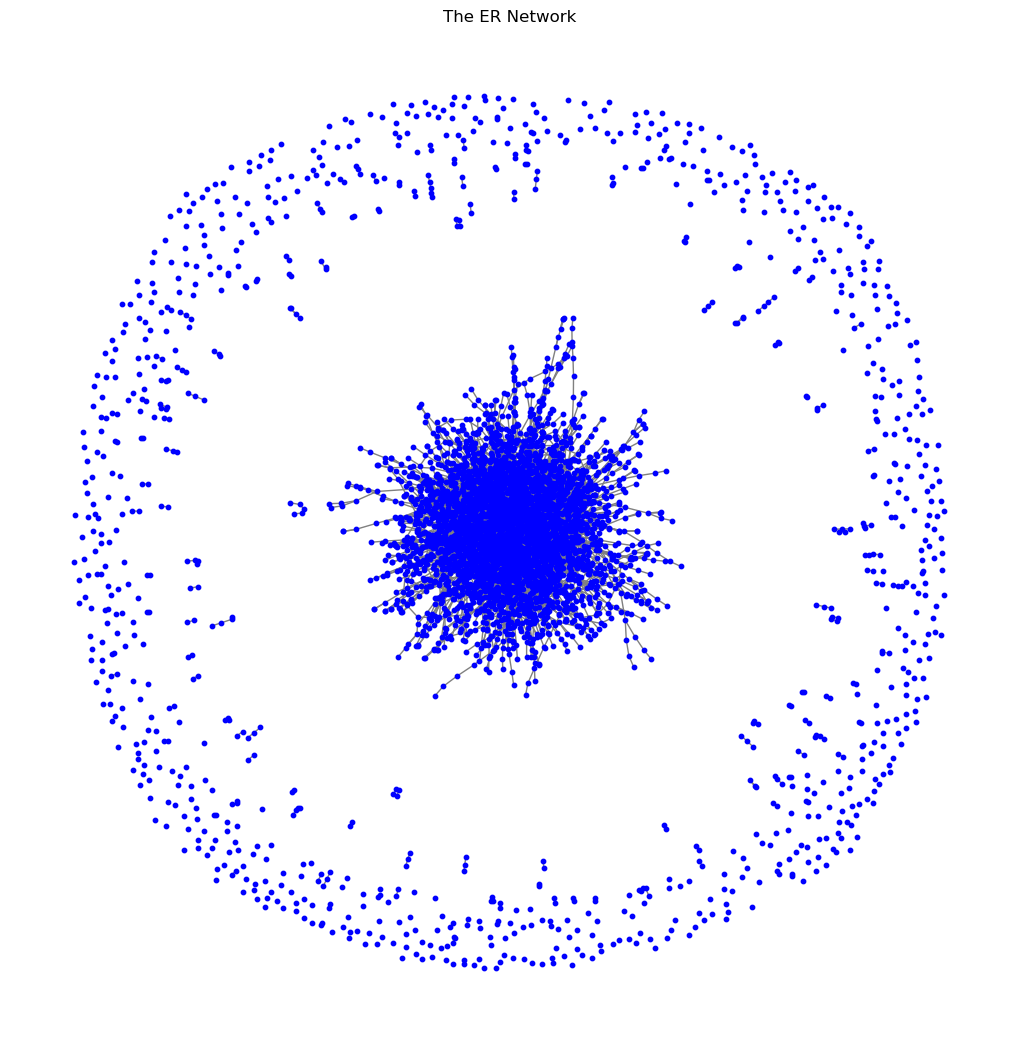

In [16]:
# Counting the number of edges in the Sune-network
num_edges = Sune_network.number_of_edges()

# Generate ER network with the same number of nodes and edges
ER_network = nx.gnm_random_graph(num_nodes, num_edges)

# Plot the ER Network
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(ER_network, seed=42)
nx.draw(ER_network, pos, node_size=10, edge_color="gray", node_color="blue", with_labels=False)

plt.title("The ER Network")
plt.show()

The Sune-network is grown similarly to the BA model but without preferential attachment, making connections purely 
random among existing nodes.

The ER network is generated using the same number of nodes (5000) and edges as the Sune-network to ensure a 
fair comparison.

This is visualized in the histogram below where we compare the two degree distribution. We can here see that the Sune-Network have a more skewed distribution, with a larger number of low degree nodes. The ER Network have a more narrow degree distribution, having most nodes having degrees closer to the average degree

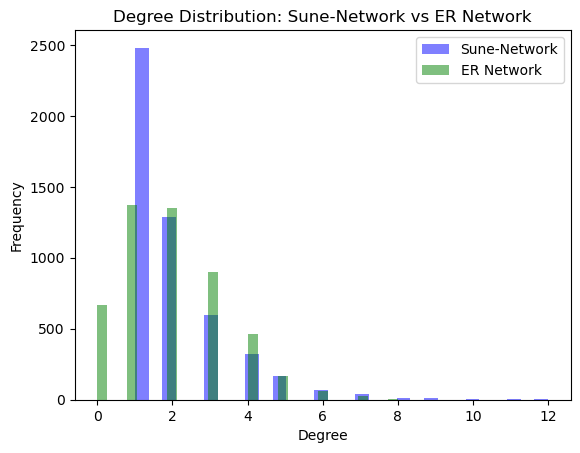

In [17]:
# Generate the Sune-Network
Sune_network = nx.Graph()
Sune_network.add_edge(0, 1)
num_nodes = 5000

for new_node in range(2, num_nodes):
    target_node = random.choice(list(Sune_network.nodes))
    Sune_network.add_edge(new_node, target_node)

# Get the number of edges in the Sune-network
num_edges = Sune_network.number_of_edges()

# Create ER network with same number of nodes and edges
ER_network = nx.gnm_random_graph(num_nodes, num_edges)

# Histogram of distribution of Sune-Network
sune_degrees = [Sune_network.degree(n) for n in Sune_network.nodes()]
plt.hist(sune_degrees, bins=30, alpha=0.5, label="Sune-Network", color="blue")

# Histogram of distribution of ER Network
er_degrees = [ER_network.degree(n) for n in ER_network.nodes()]
plt.hist(er_degrees, bins=30, alpha=0.5, label="ER Network", color="green")

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.title("Degree Distribution: Sune-Network vs ER Network")
plt.show()

The number of connected components are calculated below. Here we can see a very skewed difference between the two networks which is because of how the two networks are generated and their connection mechanisms.

The Sune-network grows by sequentially adding nodes, with each new node connecting to one existing node chosen randomly. Every new node will therefore be connected to the rest of the network and there will only be one connected component. This is visualized if we look at the previous Sune-Network plot where they are all connected.  

The ER network is generated by placing edges randomly between nodes, with no sequential growth or guarantee that new nodes connect to any specific part of the network. This is also visualized in the previous plot of the ER Network where the random components are more scattered.  

In [18]:
# Compute and Compare Number of Connected Components
sune_components = nx.number_connected_components(Sune_network)
er_components = nx.number_connected_components(ER_network)

print(f"Sune-Network has {sune_components} connected components.")
print(f"ER Network has {er_components} connected components.")

Sune-Network has 1 connected components.
ER Network has 797 connected components.


## Preamble to results in part 2 - Getting the data for the network

### Extract all links into a list of country performers
We use the wikipedia API to fetch the content of the wikipedia page: https://en.wikipedia.org/wiki/List_of_country_music_performers

In [2]:
# Creating query for fetching wiki content
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
title = "titles=List_of_country_music_performers"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

In [3]:
# HTTPrequest to get page content via Wiki API
wikiresponse = urllib.request.urlopen(query)
wikidata = wikiresponse.read()
wikitext = wikidata.decode('utf-8')
json_response = json.loads(wikitext)

In [4]:
# Get the latest page number
page = list(json_response["query"]["pages"].keys())[0]

In [5]:
# Get text content from page
text = json_response["query"]["pages"][page]["revisions"][0]["*"]

In [6]:
# Function to find any references 
# to other artist in wiki content text.
def find_all_wiki_links(text):
    # Get any strings surrounded by '[[...]]'
    pat = r'\[\[(.*?)\]\]' 
    pat = r'\[\[(?!Category:)(?!File:)(?!Image:)(.*?)\]\]'
    matches = re.findall(pat, text)
    
    # List to hold the final substrings
    results = []
    for match in matches:
        # Remove content in parentheses and split by '|'
        cleaned_substrings = re.sub(r'\s*\(.*?\)\s*', '', match).split('|')
        results.extend(cleaned_substrings)
    
    # Create urls from wiki links one at a time while replacing spaces with '_' 
    urls = []
    for res in results:
        res = res.replace(" ", "_")
        urls.append("https://en.wikipedia.org/wiki/" + res)

    # Remove dublicate results and urls
    results = list(dict.fromkeys(results))
    urls = list(dict.fromkeys(urls))
    
    return urls, results 

In [7]:
# Find all wiki_link urls and store artist names in results
urls, results = find_all_wiki_links(text)

In [8]:
# Folder to store the text files
cwd = os.getcwd()
folder_name = "wiki_text"
folder_path = os.path.join(cwd, folder_name)

In [9]:
# Check if the folder exists, otherwise create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [10]:
# Create HTTP query for requesting
# content from artist's wiki page.
# The function returns the content
# as a string.
# If the artist doesn't give any hits,
# nor redirects, it returns -1.
def get_result_content(result):
    # Create query using wikipedia's API
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    
    # Add '_' for proper url format
    result = result.replace(" ", "_")
    
    # Use urllib.parse.quote to encode special characters
    title = f"titles={urllib.parse.quote(result)}"
    
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    # Get http response from query and decode it
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    json_response = json.loads(wikitext)
    
    # Find latest page and fetch content
    page = list(json_response["query"]["pages"].keys())[0]
    
    # The name gave no hits nor redirects
    if page == '-1':
        return -1
    
    url_content = json_response["query"]["pages"][page]["revisions"][0]["*"]
    
    # Check if the name is redirected, in which case return redirected result
    redirect = re.findall(r'(?<=#redirect )\[\[(.*?)\]\]', url_content)
    if redirect:
        return get_result_content(redirect[0])
    
    return url_content

In [11]:
# The function uses get_result_content()
# to get the wiki page content of a parsed artist.
# It then stores the content in a .txt file in
# the designated folder.
def save_wikitext_to_txt(name):
    # Artist name becomes the name of the .txt file
    file_name = name

    # Pre-cleans artist name so the file does not get corrupted 
    file_name = re.sub(r'[^a-zA-Z0-9]', '_', file_name) + ".txt"
    
    # File path to where the file will be stored
    file_path = os.path.join(folder_path, file_name)
    
    content = get_result_content(name)
    
    # The name gave no hits nor redirects
    if content == -1:
        return -1
    
    # Create/open file and write content from url
    with open(file_path,'w',encoding='utf-8') as file :
        file.write(content.encode('utf-8').decode('utf-8'))
        file.close()

In [12]:
# Save txt file for every artist in the list
for name in results:
    # Check if file already exists
    name_txt = re.sub(r'[^a-zA-Z0-9]', '_', name) + ".txt"
    if not os.path.exists(os.path.join(folder_path, name_txt)):    
        # The artist name did not lead to any wiki page
        if get_result_content(name)==-1:
            results.remove(name)
        else:
            save_wikitext_to_txt(name)

In [13]:
# Remove any artist which did not lead to any wiki page
# and update results accordingly
folder_content = os.listdir(folder_path)
new_results = []
for file_name in folder_content:
    for res in results:
        res_name = re.sub(r'[^a-zA-Z0-9]', '_', res) + ".txt"
        if file_name == res_name:
            new_results.append(res)
            continue
            
# Update results in the same order as the file directory
results = new_results

In [14]:
# Function to find all outgoing links to other artists.
# Returns list of lists with artist names.
def get_all_outgoing_links_as_list(file_content):
    # Find all wiki_link urls and print them out
    file_urls, file_results = find_all_wiki_links(file_content)

    # Extract links which are in both the artists wiki as well as in the list of artists
    links = [link for link in file_results if link in results]
    
    return links

In [15]:
# Create list of outgoing references (links) to other artists
list_of_link_lists = []
for txt_file in folder_content:
    file_path = os.path.join(folder_path, txt_file)
    
    # load text from .txt file
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()

    link_list = get_all_outgoing_links_as_list(file_content)
    list_of_link_lists.append(link_list)

In [16]:
# Create dictonary to join artist with outgoing links
keys = results
values = list_of_link_lists
dict_of_link_lists = dict(zip(keys, values))

In [17]:
# Create dictonary to join artist with txt file
keys = results
values = folder_content
dict_of_txt_files = dict(zip(keys, values))

In [18]:
# Function to count the number of words in the wiki content from a txt file
def get_length_of_the_content(txt_file):
    # Create file path
    file_path = os.path.join(folder_path, txt_file)
    
    # load text from .txt file
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
    
    # Match any word of consecutive characters
    pat = r'\w+'
    words = re.findall(pat, file_content)
    
    return len(words)

### Build network based on txt files
With all the web scrapping done and the .txt files created, we are now able to create a network with country artists as nodes and their outgoing wiki links to each other as links.

We initialise our network as a directed graph with a node for each artist in the result list.

In [19]:
G = nx.DiGraph()

# Add a node for each artist and then add all outgoing links
for k, v in dict_of_link_lists.items():
    G.add_node(
        k, 
        txt_file = dict_of_txt_files[k],
        length_of_content = get_length_of_the_content(dict_of_txt_files[k])
    )
    G.add_edges_from([(k,n) for n in v])

Then, we can extract the largest weakly connected component.

This component is then used to create a subgraph, which will be used in Part 2 of this assignment.

In [20]:
# Extract the largest connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)

# Create new graph from largest connected component
S = G.subgraph(largest_cc).copy()

## Part 2: Stats of the Country Music Network

#### Simple network statistics and analysis
For the following calculations, graphs, statistics etc. the largest connected component was used.

> Note: Since 'country music' does not refer to an artist but the genre itself, we will manually remove it from the network:

In [21]:
S.remove_node('country music')

<font color='gray'> What is the number of nodes in the network?</font>

From the below code, we got 2000 nodes. (_When including the genre, the number is 2001 nodes_)

In [22]:
no_nodes = len(S.nodes())
no_nodes

2000

<font color='gray'> More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)</font>

From the below code, we got 17173 edges. (_When including the genre, the number is 18683 edges_)

In [23]:
no_edges = len(S.edges())
no_edges

17173

<font color='gray'> Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?</font>

In [24]:
# sort nodes after in/out-degree
S_sorted_in_degree = sorted(S.in_degree, key=lambda x: x[1], reverse=True)
S_sorted_out_degree = sorted(S.out_degree, key=lambda x: x[1], reverse=True)

In [25]:
# Extract in/out-degree from nodes and store separately
S_in_degree_values = [x[1] for x in S_sorted_in_degree]
S_out_degree_values = [x[1] for x in S_sorted_out_degree]

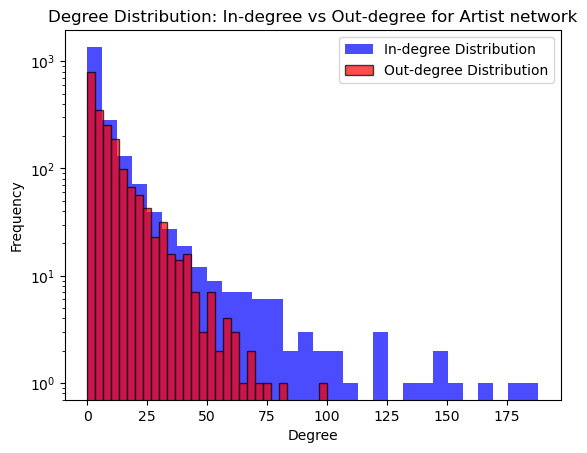

In [26]:
# Histogram of In-degree Distribution
plt.hist(
    S_in_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="In-degree Distribution", 
    color="blue"
)

# Histogram of Out-degree Distribution
plt.hist(
    S_out_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Out-degree Distribution", 
    color="red",
    edgecolor="black"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree vs Out-degree for Artist network")
plt.show()

#### Visual analysis of degree distributions
The histogram is plotted on a logarithmic scale and shows the frequency of nodes with a given degree. 

There is a characteristic heavy tail on the in-degree distribution. This suggests the presence of some very high in-degree nodes. These are highly referenced artist pages, such as Johnny Cash and Dolly Parton. 

The out-degree distribution is slightly more constrained to the 'lower' degrees. This might be due to most artist's pages focusing primarily on the artist’s own biography and career. This would in return limit the number of outgoing links, leading to a relatively lower out-degree distribution.

* <font color='gray'>  Compare the out-degree distribution to a random network with the same number of nodes and links.</font>

#### Compare degree distributions to randomly generated network
We start by generating a random network with nodes and edges equal to that of the country artists network.

In [27]:
# Create a random directed graph with n nodes and e edges
RG = nx.gnm_random_graph(no_nodes, no_edges, directed=True)

In [28]:
# sort nodes after in/out-degree
RG_sorted_in_degree = sorted(RG.in_degree, key=lambda x: x[1], reverse=True)
RG_sorted_out_degree = sorted(RG.out_degree, key=lambda x: x[1], reverse=True)

In [29]:
# Extract in/out-degree from nodes and store separately
RG_in_degree_values = [x[1] for x in RG_sorted_in_degree]
RG_out_degree_values = [x[1] for x in RG_sorted_out_degree]

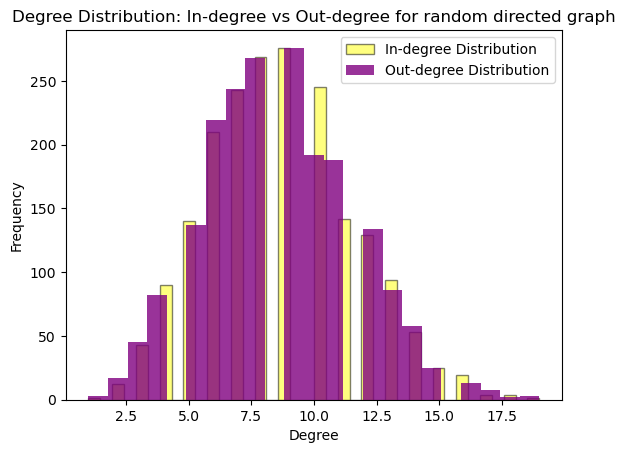

In [30]:
# The random directed graph
# Histogram of Out-degree Distribution
plt.hist(
    RG_out_degree_values, 
    bins='auto', 
    alpha=0.8, 
    label="Out-degree Distribution", 
    color="purple"
)

# Histogram of In-degree Distribution
plt.hist(
    RG_in_degree_values, 
    bins='auto', 
    alpha=0.5, 
    label="In-degree Distribution", 
    color="yellow",
    edgecolor="black"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
# plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree vs Out-degree for random directed graph")
plt.show()

By comparing the out-degree distributions of the two histograms, it is clear there is a differnce.

While random networks are said to follow a Poisson distribution centered around the mean degree, real networks do not follow this behaviour. 

Real networks are often said to follow a power-law distribution, where most of the nodes have very few links, i.e. small degree, while a small number of nodes, called hubs, have a very large number of links, i.e. high degree. 

This goes is visually demonstrated by the heavy tail observed in the artist netwok's degree distributions. 

* <font color='gray'> Compare the in-degree distribution to a scale-free network with the same number of nodes.</font> 

#### Compare degree distributions to scale-free network
We start by generating a scale-free network with nodes and edges equal to that of the country artists network.

In [33]:
# Calculate the number of edges to attach from a new node to existing nodes.
# Ensure m is at least 1 so each node is connected to at least one other node
m = max(1, math.floor(no_edges / no_nodes))

# Create a scale-free network using the Barabási-Albert model
SFG = nx.barabasi_albert_graph(no_nodes, m)

In [34]:
# sort nodes after in/out-degree
SFG_sorted_degree = sorted(SFG.degree, key=lambda x: x[1], reverse=True)

In [35]:
# Extract in/out-degree from nodes and store separately
SFG_degree_values = [x[1] for x in SFG_sorted_degree]

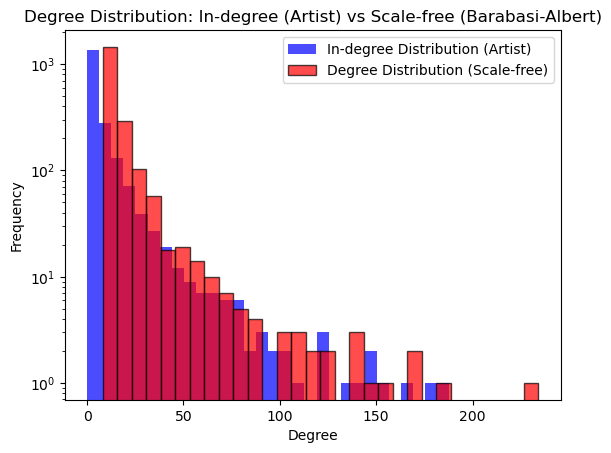

In [36]:
# Histogram of Artist In-degree Distribution vs Scale-free degree
plt.hist(
    S_in_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="In-degree Distribution (Artist)", 
    color="blue"
)

# Histogram of Out-degree Distribution
plt.hist(
    SFG_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Degree Distribution (Scale-free)", 
    color="red",
    edgecolor="black"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution: In-degree (Artist) vs Scale-free (Barabasi-Albert)")
plt.show()

As shown by the histograms above, the scale-free network simulates the real-world artist network very well. 

One of the key aspects of scale-free networks is _'preferential attachment'_ where new nodes (_artists_) tend to connect to existing nodes (Famous legacy artists).

This in turn leads to the formation of hubs, and is known as the _"rich-get-richer"_ mechanism.

If we think about this in more concrete matters: Dolly Parton has been a very well-known Country artist for decades now. It makes sense that whenever a singer with similar vocals, music or fashion style will pay homage to Parton, but only in an out-going reference.  

<font color='gray'> Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?</font>

##### In-degree
The artists with the highest in-degree, are expected to be well-known artist from previous decades with massive influence on the genre, such as Dolly Parton and Willie Nelson:

In [37]:
i = 1
for node, in_degree in S_sorted_in_degree[:5]:
    idx = f"{i}. "
    name = f"{node}"
    degree = f"{in_degree}"

    line = [idx, name, degree]
    print("{: >4} {: <18}: {:}".format(*line))
    i = i+1

 1.  Willie Nelson     : 188
 2.  Johnny Cash       : 179
 3.  Elvis Presley     : 167
 4.  Dolly Parton      : 152
 5.  George Jones      : 146


As predicted, all of the 5 artist are huge in the American Country music halls of fame. Also, these are all artist with many decades of massive musical influence. The fact that 3 out of the 5 of them are deceased, they will most likely continue to grow their heritage through new artists. 

##### Out-degree
The artists with the highest out-degree, might be artists who have been in multiple bands over the years. 

Perhaps their wikipedia pages cover their musical influence from other artists:

In [38]:
i = 1
for node, out_degree in S_sorted_out_degree[:5]:
    idx = f"{i}. "
    name = f"{node}"
    degree = f"{out_degree}"
    length = f"{S.nodes()[node].get('length_of_content')}"

    line = [idx, name, degree, length]
    print("{: >4} {: <17} degree : {: <5} Length : {: <4}".format(*line))
    i = i+1

 1.  Hillary Lindsey   degree : 100   Length : 5374
 2.  Pam Tillis        degree : 83    Length : 10173
 3.  Randy Travis      degree : 76    Length : 16113
 4.  Vince Gill        degree : 72    Length : 13724
 5.  Patty Loveless    degree : 69    Length : 10394


If we look at the wikipedia page of Hillary Lindsey, we will find that she has had a long career of co-writing songs with other artists. This list turns out to be rather cumbersome which explains her very high out-degree. Without looking too much into the others on this list it might be a fair assumption, that musicians with many outgoing references have a history of songwriting or producing with other known artists. 

<font color='gray'> What are the 10 pages with the longest wiki entries? (use the length of content attribute to figure this one out)?</font>

In [39]:
# Access the 'length_of_content' for all nodes
length_of_content_dict = nx.get_node_attributes(S, 'length_of_content')

# Sort the nodes by 'length_of_content' in descending order
sorted_nodes = sorted(
    length_of_content_dict.items(), 
    key=lambda x: x[1], 
    reverse=True
)

# Get the top 10 nodes
top_10_nodes = sorted_nodes[:10]

# top_10_nodes contains tuples of (node, length_of_content)
i = 1
for node, length_of_content in top_10_nodes:
    idx = f"{i}. "
    name = f"{node}"
    length = f"{length_of_content}"
    
    line = [idx, name, length]
    print("{: >4} {: <18}: {:}".format(*line))
    i = i+1

 1.  Beyoncé           : 62853
 2.  Taylor Swift      : 56429
 3.  Miley Cyrus       : 51262
 4.  Justin Bieber     : 50694
 5.  Carrie Underwood  : 45243
 6.  Justin Timberlake : 44779
 7.  Demi Lovato       : 44012
 8.  Bob Dylan         : 41141
 9.  Ed Sheeran        : 36312
10.  Alabama           : 34386


This list is a bit suprising - and then again not so much. 

Not so suprissing is that 7 out of the 10 artists are rather young and extremely popular artists in the modern music scene. 
This means that a lot of young fans, who are bit tech-savy, can edit their wikipedia pages with the latest gossip and musical achievements.    

However, it might be a bit suprising to find singers such as Justin Bieber, Justin Timberlake and Ed Sheeran on a Country music artist list when they are very popular pop-music artists. Also, the no. 1, Beyoncé has not had much connection to the country music scene before her recently published album featuring country inspired hits and featuring no. 3 on the list, Miley Cyrus. 

#### Let's build a simple visualization of the network


1. <font color='gray'> For the sake of the visualisation, let's convert our network to undirected graph (tip: There is a NetworkX command to help you).</font>

In [40]:
# Use build-in function for converting from directed to undirected graph
DS = S.to_undirected()

2. <font color='gray'> Use the NetworkX command nx.draw_kamada_kawai to draw the resulting undirected network. (You can find background on the algorithm here.)</font>


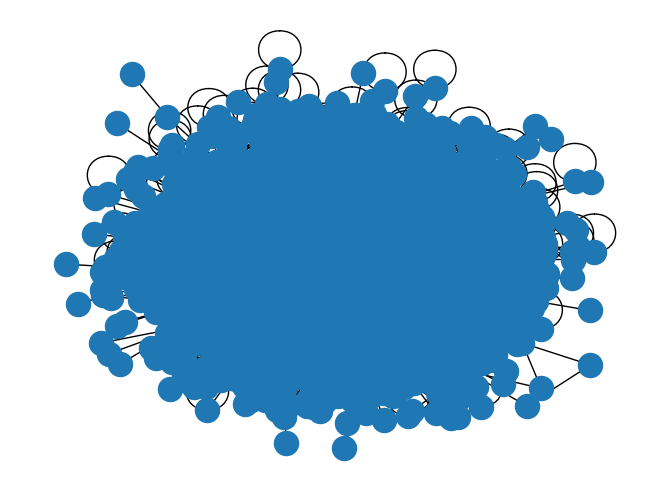

In [41]:
# Quick Sketch without parameters or special features
nx.draw(DS, pos = nx.kamada_kawai_layout(DS))

<font color='gray'>Set up your plot so that node-size depends on the node degree. </font>

In [42]:
# Get all degrees in order with the nodes
DS_degrees = sorted(DS.degree, key=lambda x: x[1], reverse=True)
DS_degree_values = [x[1] for x in DS_degrees]

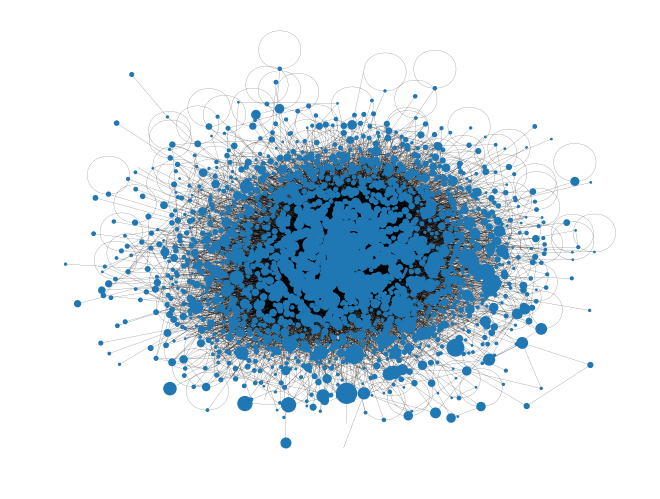

In [43]:
# Sketch out the with node sizes based on degree 
nx.draw(
    DS, 
    pos = nx.kamada_kawai_layout(DS),
    node_size = DS_degree_values,
    width = 0.1
)

<font color='gray'> Make the node color depend on the length of content attribute. I recommend choosing a color scheme that is quite simple (e.g. the Sequential ones here: https://matplotlib.org/stable/users/explain/colors/colormaps.html)</font>

In [54]:
# Remove self-loops in order to make the final plot prettier.
DS.remove_edges_from(list(nx.selfloop_edges(DS)))

In [50]:
# Helper function for normalisation of attribute values to fit colormap [0 to 1]  
def normalise(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5

In [51]:
# Function to assign color to a node based on length of content
def color_nodes_by_length(G, cmap_name = 'viridis'):

    # Get the 'length_of_content' attribute for each node
    length_values = [G.nodes[node]['length_of_content'] for node in G.nodes if 'length_of_content' in G.nodes[node]]

    # Use the parsed name to fetch the colormap from library 
    cmap = colormaps[cmap_name]
    
    # Range for normalisation of the values
    min_length = min(length_values)
    max_length = max(length_values)

    # Map each node's 'length_of_content' value to a color gradiant
    node_colors = []
    for node in G.nodes:
        if 'length_of_content' in G.nodes[node]:
            normalised_value = normalise(G.nodes[node]['length_of_content'], min_length, max_length)
            node_colors.append(cmap(normalised_value))
        else:
            # If the node has no 'length_to_content' attribute, 
            # assign default color of black
            node_colors.append((0, 0, 0, 1))

    return node_colors

In [52]:
# Get node colors based on 'length' attribute
node_colors = color_nodes_by_length(DS, cmap_name = 'rainbow')

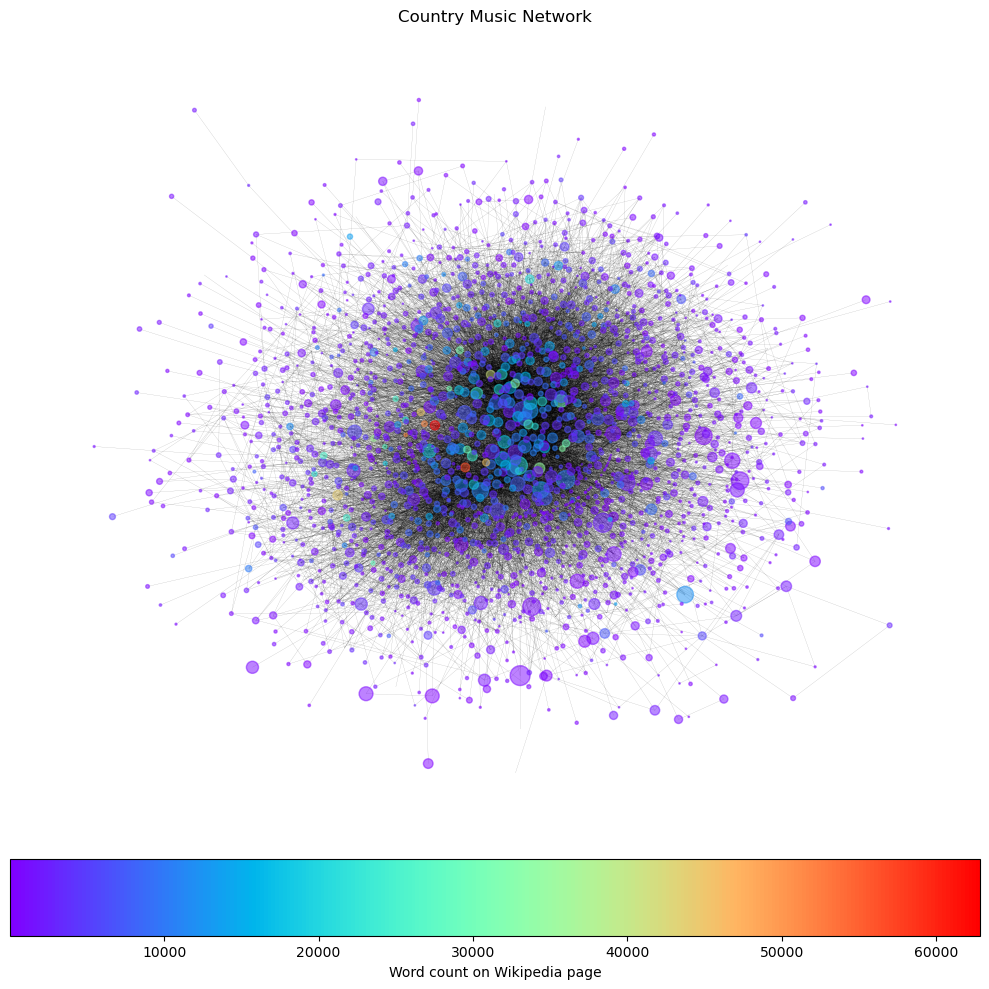

In [69]:
# Define figure size and gridspec layout
fig = plt.figure(figsize=(10, 10))

# Divide the figure into 10 equal rows
gs = fig.add_gridspec(10, 1)

# Set title of plot
ax_graph.set_title("Country Music Network\Nodes represent artists and edges are references to others")

# Graph plot (top 9/10 of the figure)
ax_graph = fig.add_subplot(gs[:9, 0])
nx.draw(
    DS,
    pos=nx.kamada_kawai_layout(DS),
    ax=ax_graph,  # Use the defined axis
    node_size=DS_degree_values,
    alpha=0.5,
    node_color=node_colors,
    width=0.1,
    with_labels=False
)

# Colorbar plot (bottom 1/10 of the figure)
ax_colorbar = fig.add_subplot(gs[9, 0])  # The bottom 1 row for the colorbar

# Colorbar code
vals = [DS.nodes[node]['length_of_content'] for node in DS.nodes if 'length_of_content' in DS.nodes[node]]
cmap = colormaps['rainbow']
norm = mpl.colors.Normalize(vmin=min(vals), vmax=max(vals))

# Create the colorbar on the designated axis
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax_colorbar,
    orientation='horizontal',
    label='Word count on Wikipedia page'
)

# Adjust layout to ensure colorbar and graph are not overlapping
plt.tight_layout()
plt.show()